# Load in the data and normalise

This takes a while so I add print statements to show when it's done...

In [1]:
! ls -l ../dataset/

total 156656392
-rw-r--r--  1 sarmadtarar  staff      3258527 23 Apr 16:47 dataset_sample.csv
-rw-r--r--@ 1 sarmadtarar  staff    176473873 27 Apr 13:30 groupby_results_weekdayy_groupby_means.csv
-rw-r--r--@ 1 sarmadtarar  staff    169368141 27 Apr 13:30 groupby_results_weekend_groupby_means.csv
-rw-r--r--@ 1 sarmadtarar  staff  39929480142 24 Apr 17:12 qut_it_capstone_ailbatross_20181029_nmi_data_20181029.csv
-rw-r--r--@ 1 sarmadtarar  staff  28630797979 25 Apr 16:20 weekday_split_weekdays.csv
-rw-r--r--@ 1 sarmadtarar  staff  11298682219 25 Apr 16:30 weekday_split_weekends.csv


In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

numeric_columns = [f'ekw{i+1}' for i in range(48)]

scaler = MinMaxScaler()

weekends_df = pd.read_csv('../dataset/groupby_results_weekend_groupby_means.csv', index_col='nmi_uuid')
weekdays_df = pd.read_csv('../dataset/groupby_results_weekdayy_groupby_means.csv', index_col='nmi_uuid')

weekends_df[numeric_columns] = scaler.fit_transform(
                                    weekends_df[numeric_columns].transpose()
                                ).transpose()

weekdays_df[numeric_columns] = scaler.fit_transform(
                                    weekdays_df[numeric_columns].transpose()
                                ).transpose()

print('Data is normalised and ready to be processed')

Data is normalised and ready to be processed


# Sanity Check

Remove bad rows

In [28]:
bad_rows = weekends_df[~(weekends_df[[f'ekw{i+1}' for i in range(48)]] > 0.99).any(axis=1)] # all rows should range between 0 and 1

bad_rows.head() # these rows have something wrong with them..

,ekw1,ekw2,ekw3,ekw4,ekw5,ekw6,ekw7,ekw8,ekw9,ekw10,...,ekw39,ekw40,ekw41,ekw42,ekw43,ekw44,ekw45,ekw46,ekw47,ekw48
nmi_uuid,,,,,,,,,,,,,,,,,,,,,
202b5475-ef48-4c71-9c1a-26f27ec0faac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2676328b-cac3-4801-b6ef-09d25e9696e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2b06621a-9e3e-4986-a198-c5b3c9efcdc8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324d1e0f-7881-4810-b41e-2b80862e2ebb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325f230a-c2de-44dc-85e0-d4dee4dd8867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
weekends_df = weekends_df[(weekends_df[[f'ekw{i+1}' for i in range(48)]] > 0.99).any(axis=1)] # all rows should range between 0 and 1

weekends_df.head()

,ekw1,ekw2,ekw3,ekw4,ekw5,ekw6,ekw7,ekw8,ekw9,ekw10,...,ekw39,ekw40,ekw41,ekw42,ekw43,ekw44,ekw45,ekw46,ekw47,ekw48
nmi_uuid,,,,,,,,,,,,,,,,,,,,,
0018cc7a-2c30-4922-9302-802bd2b2084f,0.321625,0.274449,0.250689,0.229855,0.203340,0.197486,0.193182,0.264463,1.000000,0.411157,...,0.576102,0.544249,0.471074,0.501205,0.343836,0.418733,0.363292,0.318010,0.270833,0.347796
008736af-a01c-4715-bdd9-d6aa1694a5d0,0.408637,0.194922,0.197921,0.389844,0.407637,0.653938,0.225110,0.381248,0.533187,0.694922,...,0.418832,0.356857,0.978409,0.285486,0.801080,0.670532,0.497401,0.380848,0.076969,0.073171
0088ea6e-6d7a-49f6-b1f5-2d09fc3358ba,0.228623,0.233432,0.259102,0.162799,0.155249,0.192998,0.025334,0.012919,0.072255,0.000000,...,0.100498,0.076785,0.071584,0.073989,0.880488,1.000000,0.777082,0.437559,0.293384,0.300934
00990a9e-8bda-40c4-b1a3-986dcf5d97ec,0.099850,0.080649,0.028446,0.018404,0.005884,0.005928,0.013626,0.003097,0.021545,0.011812,...,1.000000,0.926119,0.487790,0.343037,0.261414,0.267298,0.194789,0.146832,0.146700,0.120244
009f80a2-a7ef-48b5-aa92-1e358f26b0c1,0.410289,0.373275,0.377039,0.367001,0.296738,0.317440,0.351945,0.333124,0.360100,0.345671,...,0.597867,0.590966,0.604141,0.735257,0.683814,0.553952,0.512547,0.479925,0.414680,0.402133


# Test KMeans on a range of n_cluster values

We will be testing inter- and intra- cluster variances. We want to find the point where inter- cluster variances are at the highest, whereas intra- cluster variances are at the lowest. Both these criteria are just as important as each other, so it's best to get as close to the middle as possible.

This is mostly for visualisation purposes - so I scaled the variation calcs such that they fit on the same graph.


In [74]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

numeric_data = np.asarray(
    weekends_df[[f'ekw{i+1}' for i in range(48)]]
)

#clean up nans - this should have been weeded out in the previous cell anyway
nans = np.any(np.isnan(numeric_data), axis=1)
numeric_data = numeric_data[~nans]

intra_cluster_variances = np.zeros(15)
inter_cluster_variances = np.zeros(15)

for n_clusters in range(3, 18):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=20).fit(numeric_data)
    cluster_indices = kmeans.predict(numeric_data)
    
    # intra-cluster variance:
    total_intracluster_variance = np.zeros((1, 48))
    for i in range(n_clusters):
        cluster_subset = numeric_data[cluster_indices == i]
        variance = np.var(cluster_subset, axis=0) # variance along each column, NOT the flattened array
        total_intracluster_variance += variance
    
    # inter-cluster variance:
    intercluster_variance = np.var(kmeans.cluster_centers_, axis=0)
    intercluster_variance = intercluster_variance / intercluster_variance.max()
    
    intra_cluster_variances[n_clusters - 3] = np.mean(total_intracluster_variance / total_intracluster_variance.max())
    inter_cluster_variances[n_clusters - 3] = np.mean(intercluster_variance)
    
    print(f'Intra-cluster variance @ {n_clusters}', intra_cluster_variances[n_clusters - 3])
    print(f'Inter-cluster variance @ {n_clusters}', intercluster_variance[n_clusters - 3])
    
print('Done!')

Intra-cluster variance @ 3 0.7372482203243823
Inter-cluster variance @ 3 0.2399037727333975
Intra-cluster variance @ 4 0.7127484453199596
Inter-cluster variance @ 4 0.644096785479475
Intra-cluster variance @ 5 0.6817262199661761
Inter-cluster variance @ 5 0.45780925514424814
Intra-cluster variance @ 6 0.6581523847411826
Inter-cluster variance @ 6 0.6295272211513547
Intra-cluster variance @ 7 0.6256491287325522
Inter-cluster variance @ 7 0.5506067385608747
Intra-cluster variance @ 8 0.6210233589231524
Inter-cluster variance @ 8 0.4775671208529304
Intra-cluster variance @ 9 0.6282275401548877
Inter-cluster variance @ 9 0.5086165031346185
Intra-cluster variance @ 10 0.6653716952084495
Inter-cluster variance @ 10 0.4717979496402169
Intra-cluster variance @ 11 0.6322380237242312
Inter-cluster variance @ 11 0.6242201601381768
Intra-cluster variance @ 12 0.6335087538849881
Inter-cluster variance @ 12 0.6124127534770291
Intra-cluster variance @ 13 0.6304839647128988
Inter-cluster variance @ 13

# Plot variances

This is a tricky problem - how much weight do we put on inter-cluster variance and how much weight do we put on intr-cluster variance? For now, let's just assume equal weight.

/Users/sarmadtarar/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


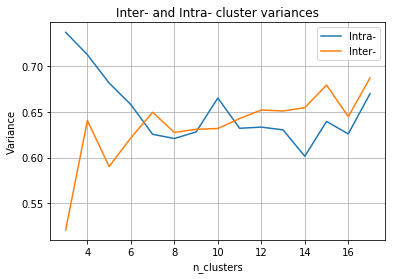

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(3, 18), intra_cluster_variances)
plt.plot(range(3, 18), inter_cluster_variances)
plt.grid('on')
plt.xlabel('n_clusters')
plt.ylabel('Variance')
plt.title('Inter- and Intra- cluster variances')
plt.legend(['Intra-', 'Inter-'])



# Visualise cluster centers

/Users/sarmadtarar/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


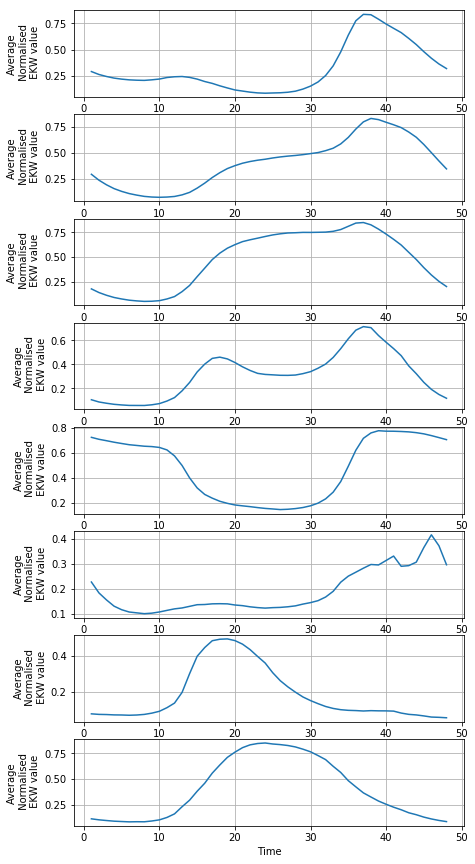

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=8, max_iter=20).fit(numeric_data)

plt.figure(
    num='Cluster centres for each user\'s averaged, normalised weekend',
    figsize=(7, 15)
)

for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(range(1, 49), kmeans.cluster_centers_[i, :])
    plt.grid('on')
    plt.ylabel('Average\n Normalised\n EKW value')
    plt.xlabel('Time')
